In [189]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

In [190]:
class CFG:
    epochs = 10
    batch_size = 32
    h = 224
    w = 224
    chn = 3
    img_size = (224, 224, 3)

## Checking dataset

In [191]:
train_path = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
test_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/'

### Number of images present in the dataset

In [192]:
train_images = glob.glob(f"{train_path}**/*.jpg")
test_images = glob.glob(f"{test_path}**/*.jpg")
train_size = len(train_images)
test_size = len(test_images)

total = train_size + test_size

print(f'train samples: {train_size}')
print(f'test samples: {test_size}')
print(f'TOTAL: {total}')

train samples: 2637
test samples: 660
TOTAL: 3297


In [193]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    df['label_encoded'] = df.label
    df.label_encoded.replace(('malignant', 'benign'), (1, 0), inplace = True)    
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

In [194]:
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

In [195]:
train_df.head()

,image_path,label,label_encoded
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1


### Viewing Random Sample Image

In [196]:
def _load(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=CFG.chn)
    
    image = tf.image.resize(image, [CFG.h, CFG.w],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    # normalizing image
    image = tf.cast(image, tf.float32)/255.0
    return image

def view_sample(image, label, color_map='rgb'):
    plt.figure(figsize=(8, 10))
    
    if color_map=='rgb':
        
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)
    
    plt.title(f'Label: {label}')
    return

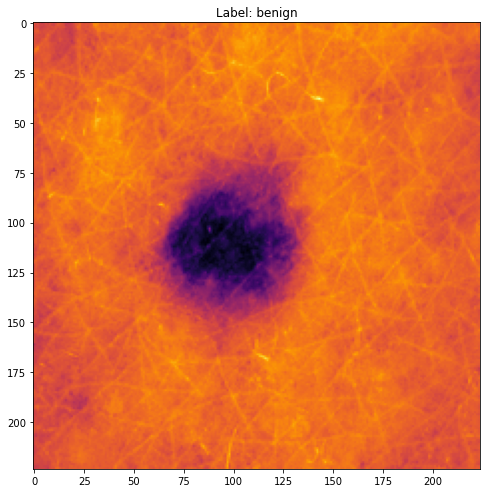

In [197]:
idx = random.sample(train_df.index.to_list(), 1)[0]
# idy = (random.sample(train_df.image_path.to_list(), 1))
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]
view_sample(sample_image, sample_label, color_map='inferno')


### View multiple random samples

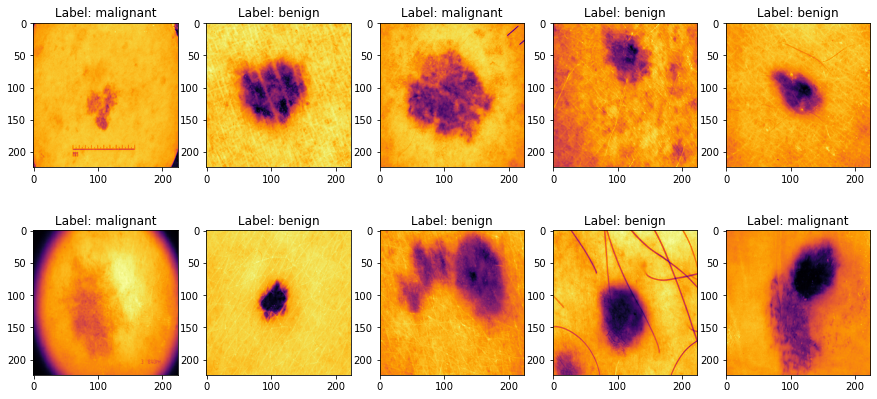

In [198]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)
    
    return

view_mulitiple_samples(train_df, _load, 
                       count=10, color_map='inferno', 
                       fig_size=(15, 7))

<a id='1.6'></a>
### View Train Labels Distribution

<AxesSubplot:title={'center':'Testing labels'}, xlabel='label_encoded', ylabel='count'>

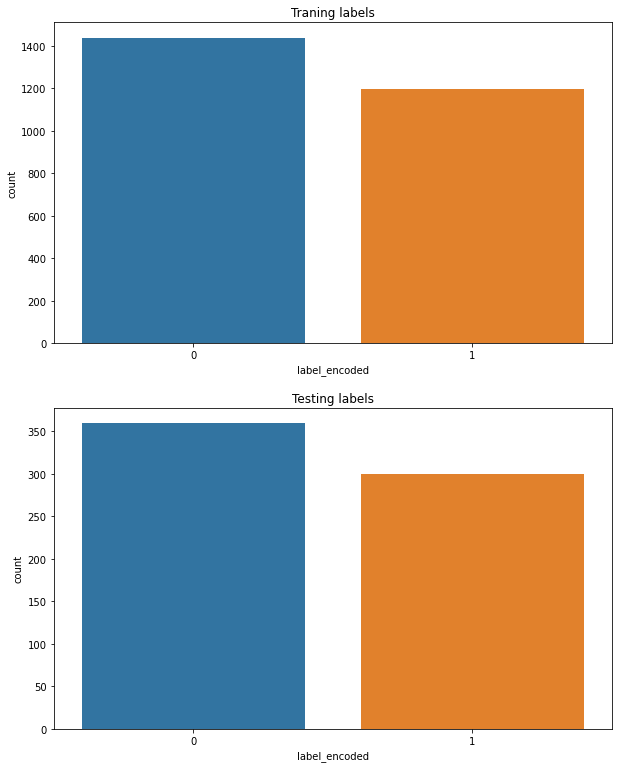

In [199]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 13))

ax1.set_title('Traning labels')
ax2.set_title('Testing labels')
sns.countplot(x = 'label_encoded', data = train_df, ax = ax1)
sns.countplot(x = 'label_encoded', data = test_df, ax = ax2)

<a id='2.1'></a>
### Create Train & Validation Splits

In [200]:
# Splitting training data in training and validation set
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index, 
                                                        train_df.label_encoded, 
                                                        test_size=0.15,
                                                        stratify=train_df.label_encoded,
                                                        random_state=42)

In [201]:
# Creating validation dataframe
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

train_new_df.shape, val_df.shape

((2241, 3), (396, 3))

<a id='2.2'></a>
### View New Train & Validation Labels Distribution

<AxesSubplot:title={'center':'Validation labels'}, xlabel='label_encoded', ylabel='count'>

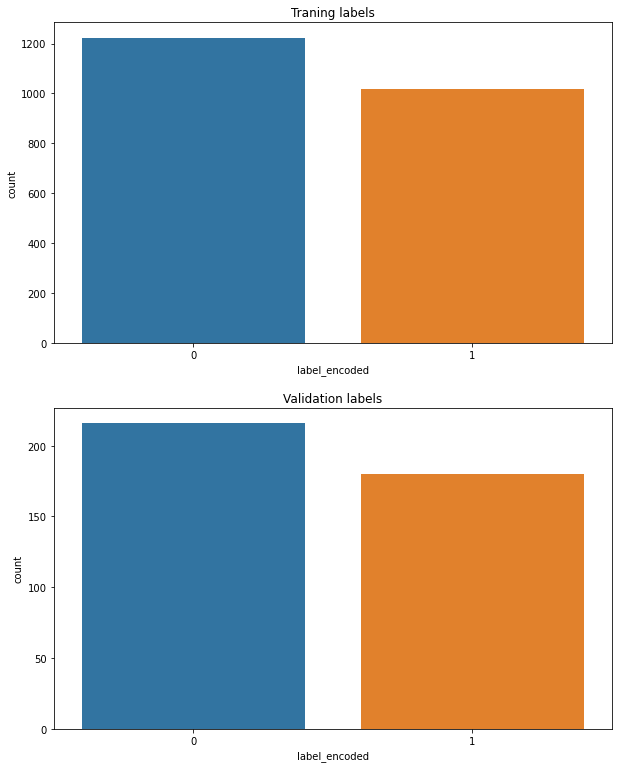

In [202]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 13))

ax1.set_title('Traning labels')
ax2.set_title('Validation labels')
sns.countplot(x = 'label_encoded', data = train_new_df, ax = ax1)
sns.countplot(x = 'label_encoded', data = val_df, ax = ax2)

<a id='2.3'></a>
### Create an Image Data Augmentation Layer

In [203]:
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=768),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=768),
], name='augmentation_layer')

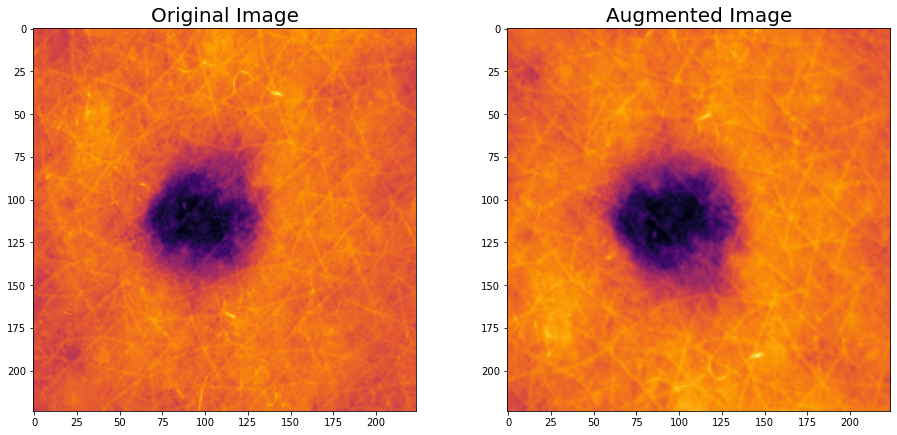

In [204]:
image = tf.image.rgb_to_grayscale(sample_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
fig.tight_layout(pad=6.0)
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(image, cmap='inferno');
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(augmentation_layer(image), cmap='inferno');

<a id='2.4'></a>
### Create Input Data Pipeline w. tf.data API

In [205]:
def encode_labels(labels, encode_depth=2):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE
    
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    if cache != None:
        ds = ds.cache(cache)
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [206]:
train_ds = create_pipeline(train_new_df, _load, augment=True, 
                           batch_size=CFG.batch_size, 
                           shuffle=False, prefetch=True)

val_ds = create_pipeline(val_df, _load, 
                         batch_size=CFG.batch_size, 
                         shuffle=False, prefetch=False)

test_ds = create_pipeline(test_df, _load, 
                          batch_size=CFG.batch_size, 
                          shuffle=False, prefetch=False)

In [207]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>
Validation Input Data Pipeline:

 <BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>
Test Input Data Pipeline:

 <BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>


## Convolutional Neural Network (CNN)

In [208]:
def cnn_model():
    
    initializer = tf.keras.initializers.GlorotNormal()
    
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.img_size, dtype=tf.float32, name='input_image'),
        
        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2, padding='valid'),
        
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, activation='sigmoid', kernel_initializer=initializer)
    ], name='cnn_sequential_model')
    
    return cnn_sequential

In [209]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 8)       1160      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 106, 106, 8)       584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 22472)    

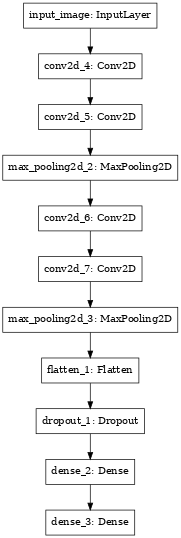

In [210]:
plot_model(model_cnn, dpi=50)

### Training CNN Model

In [211]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    model_history = {}
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data, epochs=num_epochs, validation_data=tf_valid_data, validation_steps=int(len(tf_valid_data)), callbacks=callbacks_list, shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data, epochs=num_epochs, callbacks=callbacks_list, shuffle=shuffling)
    return model_history

In [212]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.1,verbose=1)

call_backs = [early_stopping_callback, reduce_lr_callback]

In [213]:
tf.random.set_seed(42)

model_cnn.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics='accuracy')

print(f'Training {model_cnn.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')

cnn_history = train_model(
    model_cnn, CFG.epochs, call_backs, 
    train_ds, val_ds,
    shuffling=False
)

Training cnn_sequential_model.
Train on 2241 samples, validate on 396 samples.
Epoch 1/10
71/71 [==============================] - 17s 232ms/step - loss: 0.6312 - accuracy: 0.6412 - val_loss: 0.6283 - val_accuracy: 0.7045
Epoch 2/10
71/71 [==============================] - 16s 227ms/step - loss: 0.5238 - accuracy: 0.7367 - val_loss: 0.5348 - val_accuracy: 0.7576
Epoch 3/10
71/71 [==============================] - 15s 218ms/step - loss: 0.4802 - accuracy: 0.7573 - val_loss: 0.5183 - val_accuracy: 0.7576
Epoch 4/10
71/71 [==============================] - 15s 218ms/step - loss: 0.4645 - accuracy: 0.7626 - val_loss: 0.5232 - val_accuracy: 0.7601
Epoch 5/10
71/71 [==============================] - 16s 228ms/step - loss: 0.4633 - accuracy: 0.7697 - val_loss: 0.5368 - val_accuracy: 0.7601

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
71/71 [==============================] - 15s 218ms/step - loss: 0.4416 - accuracy: 0.7849 - val_loss: 0.4239 - va

In [214]:
cnn_evaluation = model_cnn.evaluate(test_ds)

21/21 [==============================] - 2s 97ms/step - loss: 0.3875 - accuracy: 0.7985


In [215]:
cnn_test_probabilities = model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1)

21/21 [==============================] - 2s 96ms/step


<a id='6.1'></a>
### Plot Model Histories 

In [216]:
def plot_training_curves(history):
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

    # Plot accuracy
    ax1.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax1.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend();

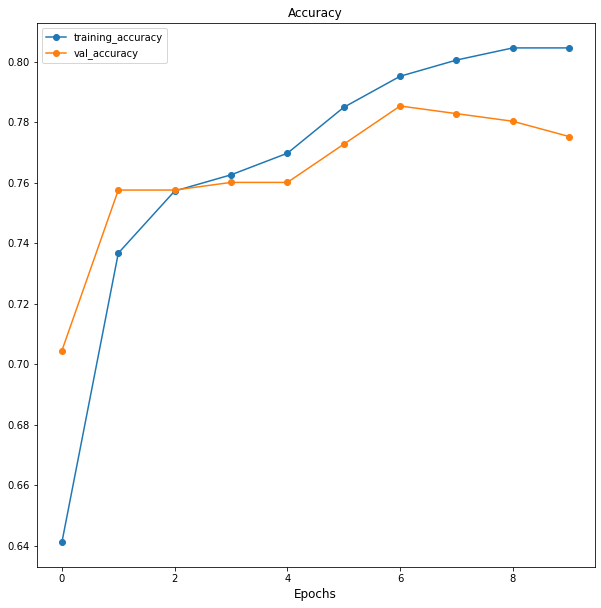

In [217]:
plot_training_curves(cnn_history)

<a id='6.2'></a>
### Plot Confusion Matrix

In [218]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10)): 
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)

    disp = sns.heatmap(cm, annot=True, cmap='Greens', xticklabels=classes, yticklabels=classes)
    
    disp.set_title('Confusion Matrix')
    disp.set_xlabel('Predicted Label') 
    disp.set_ylabel('True Label')
#     plt.yticks(rotation=0) 
    plt.show()

### CNN Confusion Matrix

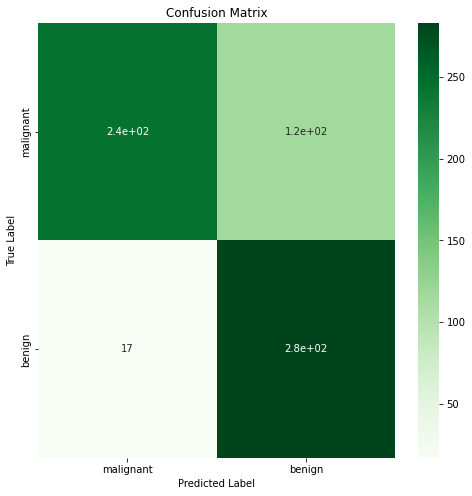

In [219]:
class_names = ['malignant', 'benign']

plot_confusion_matrix(
    test_df.label_encoded, 
    cnn_test_predictions, 
    figsize=(8, 8), 
    classes=class_names)

### CNN ROC Curves

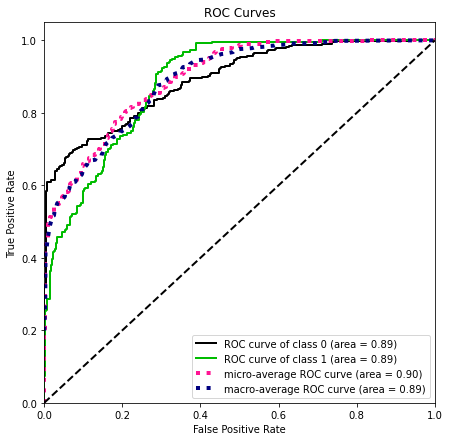

In [220]:
plot_roc(test_df.label_encoded, 
         cnn_test_probabilities, 
         figsize=(7, 7), title_fontsize='large');

In [221]:
print(classification_report(test_df.label_encoded, 
                            cnn_test_predictions, 
                            target_names=class_names))

              precision    recall  f1-score   support

   malignant       0.93      0.68      0.79       360
      benign       0.71      0.94      0.81       300

    accuracy                           0.80       660
   macro avg       0.82      0.81      0.80       660
weighted avg       0.83      0.80      0.80       660



### And we are done. Thank you!